In [53]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [54]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [55]:
# Parameters
run_id = "group.msn.hypo.10.14.ldcts"


In [56]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [57]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [58]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
63,STRv_D1_MSN,2.552038e-08,1.423998e-08,0.036553,Nalls.LancetNeurol.2019.Parkinsons_disease_,1.437073
64,STRd_D2_Matrix_MSN,1.267152e-08,8.424981e-09,0.066285,Nalls.LancetNeurol.2019.Parkinsons_disease_,1.178582
65,STRv_D2_MSN,1.357285e-08,1.019850e-08,0.091616,Nalls.LancetNeurol.2019.Parkinsons_disease_,1.038027
66,STRd_D1_Matrix_MSN,5.677669e-09,8.285704e-09,0.246597,Nalls.LancetNeurol.2019.Parkinsons_disease_,0.608012
67,STRd_D2_Striosome_MSN,6.705647e-09,1.606960e-08,0.338234,Nalls.LancetNeurol.2019.Parkinsons_disease_,0.470783


In [59]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [60]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [61]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

828     0.406775
396     0.406775
270     0.540791
702     0.540791
829     0.540791
          ...   
385     0.998427
386     0.998427
399     0.998427
381     0.998427
1034    0.998427
Name: FDR_BH_corrected, Length: 171, dtype: float64


In [62]:
print(adj_pval.sort_values())

396    0.406775
828    0.535753
270    0.540791
423    0.558276
144    0.575915
         ...   
275    1.122920
381    1.126900
744    1.126973
859    1.128776
400    1.130353
Name: adj_pval, Length: 171, dtype: float64


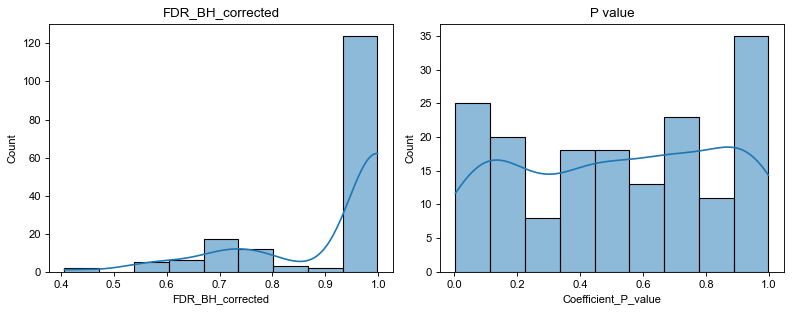

In [63]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [64]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.219192,0.402960,0.045176,0.429595,0.893027,1.108700,0.034800,0.359008,0.891832,0.364348,0.112820,0.788779,0.441297,1.053274,0.166067,1.083291,0.165928,0.132286,0.490938
STRd_D1_Matrix_MSN,0.035419,0.678865,0.197511,0.706928,0.164860,0.031743,0.338494,0.602662,0.195876,0.461838,0.608012,0.032480,0.161243,0.176568,0.172916,0.534156,0.032814,0.002591,1.076581
STRd_D1_Striosome_MSN,0.336145,0.399271,2.322612,0.016128,0.219486,0.231552,1.182228,0.110857,0.310653,0.057081,0.028704,0.260136,0.828711,0.391587,0.339310,0.118920,0.174706,0.134185,0.720696
STRd_D2_Matrix_MSN,0.015266,0.395780,0.036774,0.579482,0.179488,0.062211,0.189856,0.036076,0.259783,0.293153,1.178582,0.063832,0.234742,0.008885,0.165484,0.119606,0.037589,0.102548,1.627540
STRd_D2_StrioMat_Hybrid_MSN,1.821751,0.155375,1.432962,0.902124,0.184345,0.316000,0.271765,1.338130,0.765291,0.760261,0.045671,1.707996,1.337049,0.972093,0.127558,0.829310,1.801888,0.783999,0.001281


In [65]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.998427,0.998427,0.998427,0.998427,0.731211,0.689423,0.998427,0.998427,0.731211,0.998427,0.998427,0.781079,0.998427,0.689423,0.998427,0.689423,0.998427,0.998427,0.998427
STRd_D1_Matrix_MSN,0.998427,0.805973,0.998427,0.799501,0.998427,0.998427,0.998427,0.908314,0.998427,0.998427,0.908314,0.998427,0.998427,0.998427,0.998427,0.980099,0.998427,0.998427,0.689423
STRd_D1_Striosome_MSN,0.998427,0.998427,0.406775,0.998427,0.998427,0.998427,0.689423,0.998427,0.998427,0.998427,0.998427,0.998427,0.746116,0.998427,0.998427,0.998427,0.998427,0.998427,0.795890
STRd_D2_Matrix_MSN,0.998427,0.998427,0.998427,0.938151,0.998427,0.998427,0.998427,0.998427,0.998427,0.998427,0.689423,0.998427,0.998427,0.998427,0.998427,0.998427,0.998427,0.998427,0.575915
STRd_D2_StrioMat_Hybrid_MSN,0.540791,0.998427,0.605346,0.731211,0.998427,0.998427,0.998427,0.605346,0.781540,0.781540,0.998427,0.558276,0.605346,0.731211,0.998427,0.746116,0.540791,0.781079,0.998427


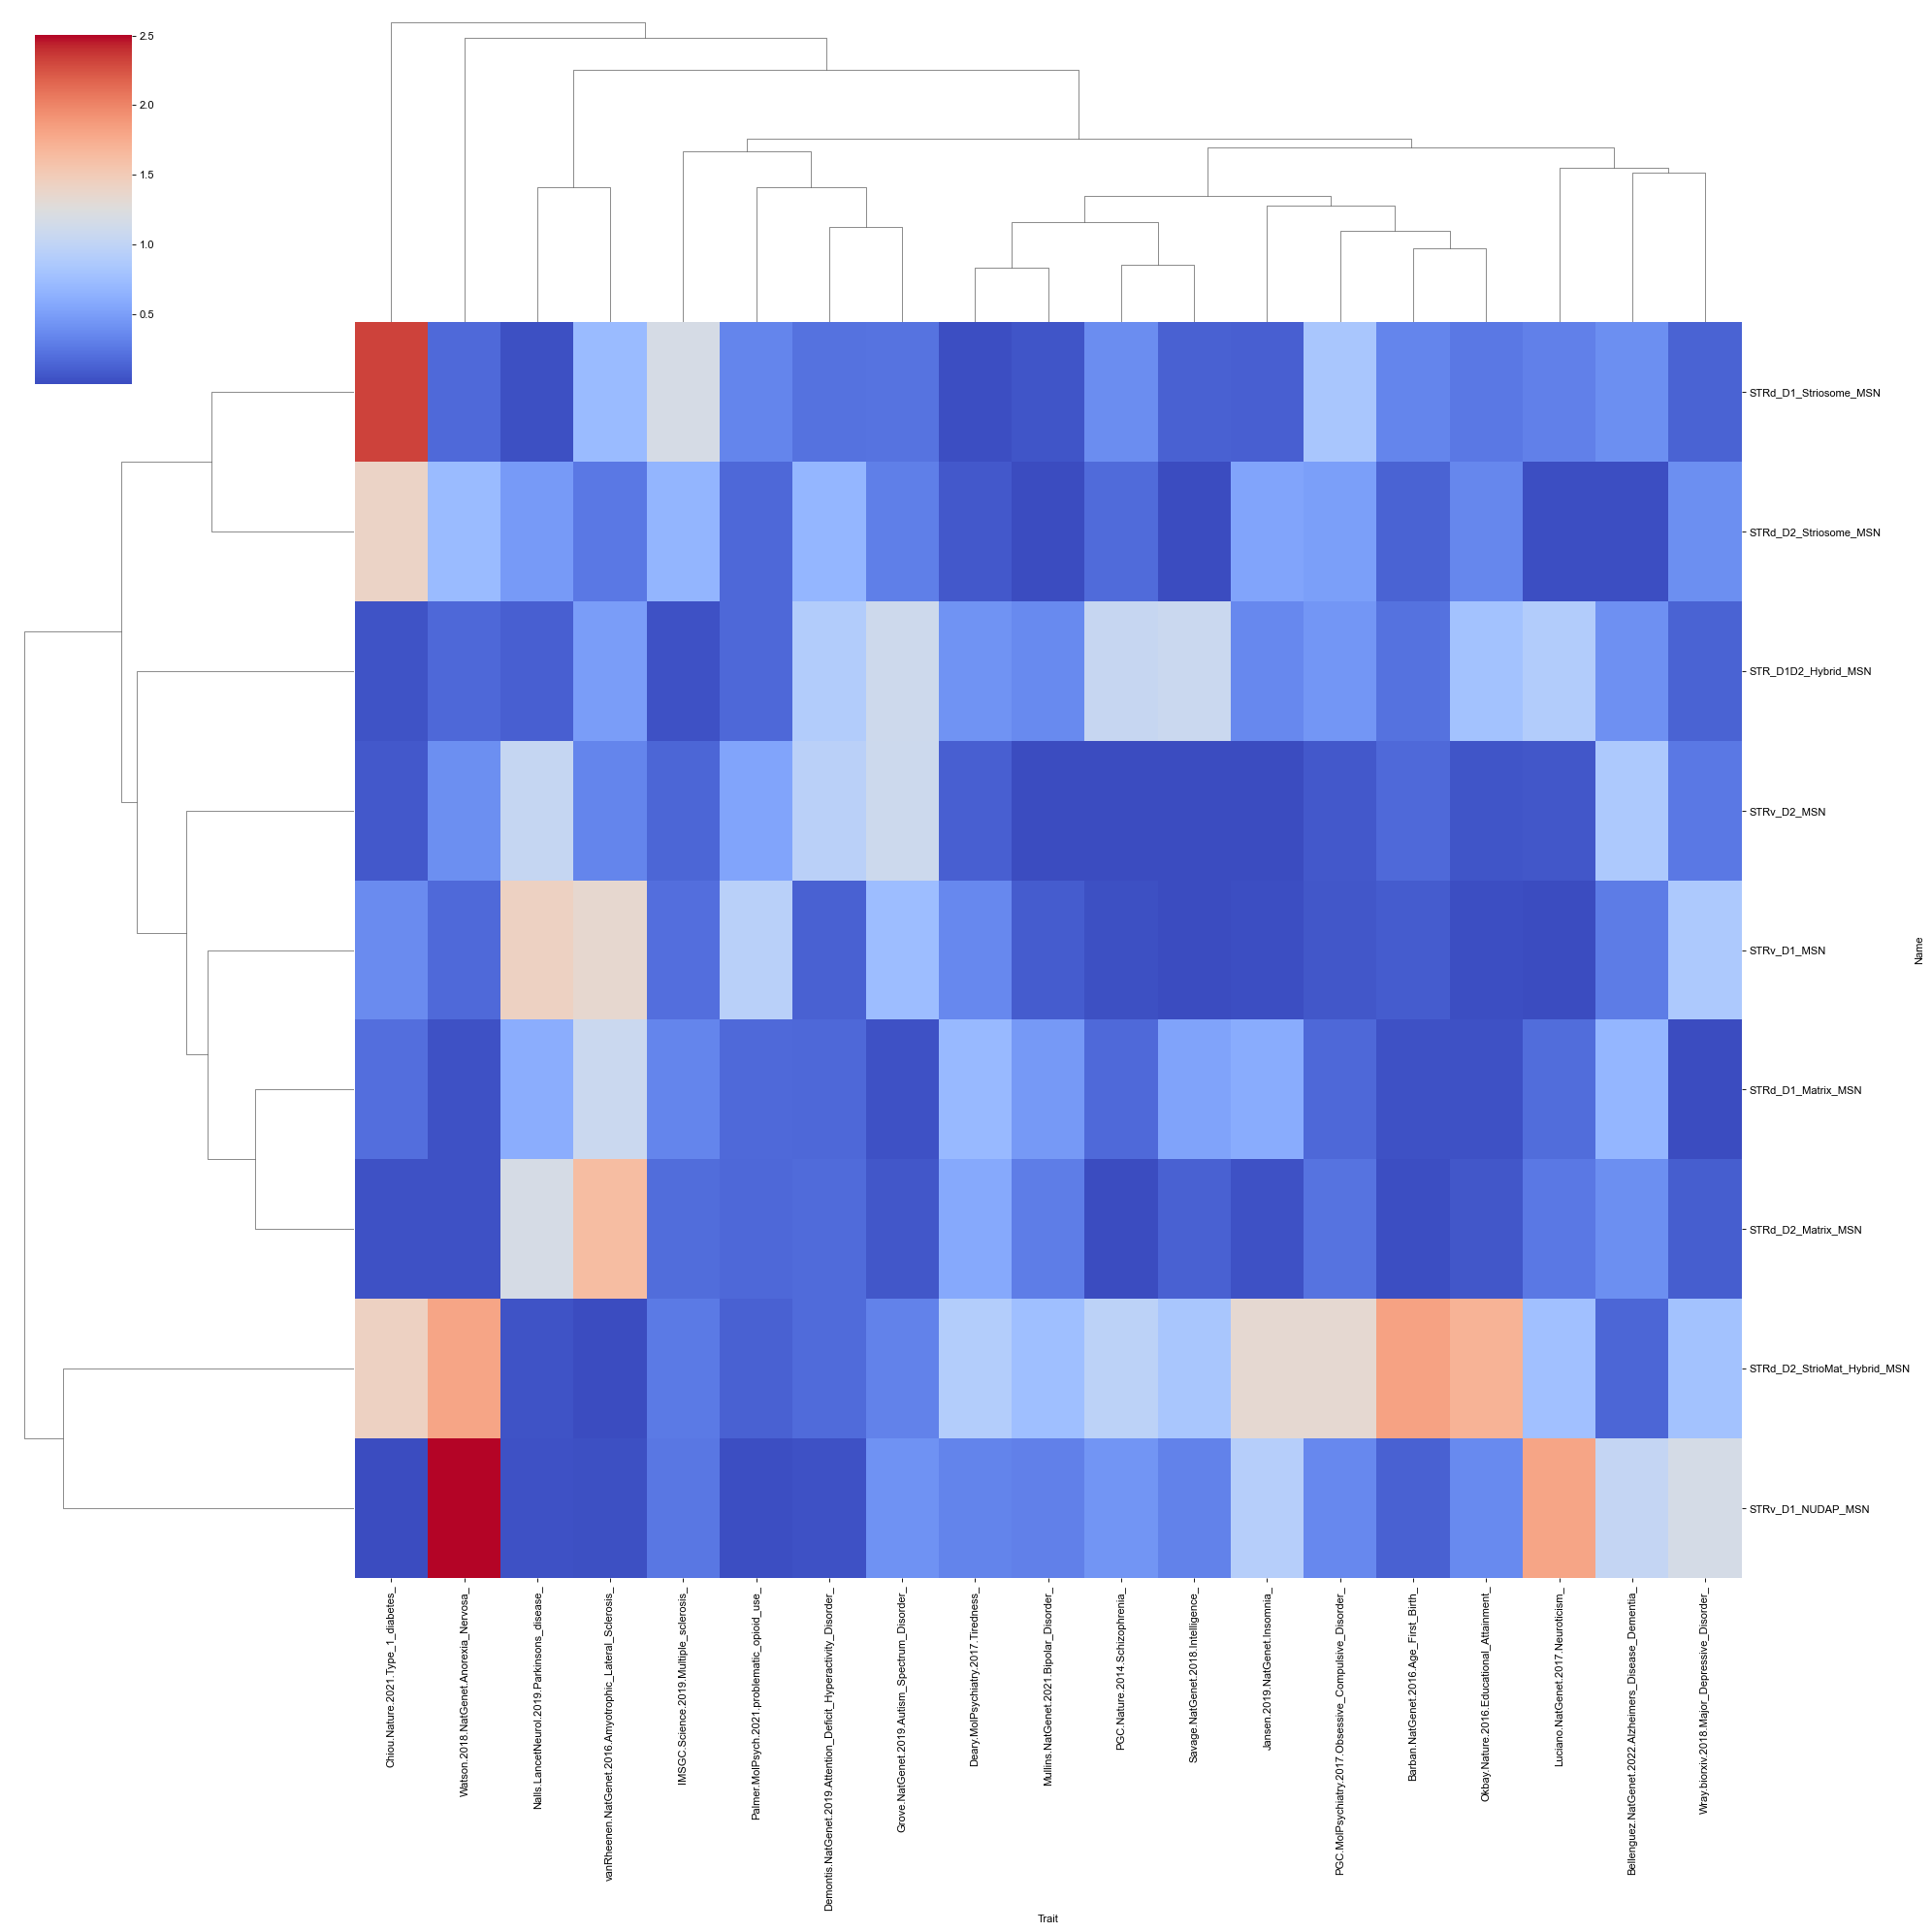

In [66]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [67]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [68]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [69]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [70]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index([], dtype='object', name='Trait')

In [71]:
modified_df

Trait,Type 1 Diabetes,Anorexia Nervosa,Parkinson's Disease,Amyotrophic Lateral Sclerosis,Multiple Sclerosis,Problematic Opioid Use,ADHD,Autism Spectrum Disorder,Tiredness,Bipolar Disorder,Schizophrenia,Intelligence,Insomnia,Obsessive Compulsive Disorder,Age at First Birth,Educational Attainment,Neuroticism,Alzheimers Disease and Dementia,Major Depressive Disorder
Name,,,,,,,,,,,,,,,,,,,
STRd_D1_Striosome_MSN,2.322612,0.174706,0.028704,0.720696,1.182228,0.339310,0.219486,0.231552,0.016128,0.057081,0.391587,0.118920,0.110857,0.828711,0.336145,0.260136,0.310653,0.399271,0.134185
STRd_D2_Striosome_MSN,1.399685,0.719359,0.470783,0.257962,0.673463,0.161831,0.680751,0.295417,0.076498,0.002446,0.184753,0.001755,0.541821,0.506336,0.133596,0.347522,0.017502,0.015842,0.399742
STR_D1D2_Hybrid_MSN,0.045176,0.165928,0.112820,0.490938,0.034800,0.166067,0.893027,1.108700,0.429595,0.364348,1.053274,1.083291,0.359008,0.441297,0.219192,0.788779,0.891832,0.402960,0.132286
STRv_D2_MSN,0.078031,0.393879,1.038027,0.342472,0.147676,0.546754,0.957773,1.097792,0.117277,0.007290,0.000684,0.005983,0.004249,0.073154,0.173500,0.050406,0.059941,0.856002,0.258737
STRv_D1_MSN,0.380141,0.167942,1.437073,1.348671,0.205327,0.942023,0.120634,0.742784,0.354811,0.096644,0.024206,0.007053,0.012891,0.065239,0.092115,0.013944,0.008551,0.281393,0.855963
STRd_D1_Matrix_MSN,0.197511,0.032814,0.608012,1.076581,0.338494,0.172916,0.164860,0.031743,0.706928,0.461838,0.176568,0.534156,0.602662,0.161243,0.035419,0.032480,0.195876,0.678865,0.002591
STRd_D2_Matrix_MSN,0.036774,0.037589,1.178582,1.627540,0.189856,0.165484,0.179488,0.062211,0.579482,0.293153,0.008885,0.119606,0.036076,0.234742,0.015266,0.063832,0.259783,0.395780,0.102548
STRd_D2_StrioMat_Hybrid_MSN,1.432962,1.801888,0.045671,0.001281,0.271765,0.127558,0.184345,0.316000,0.902124,0.760261,0.972093,0.829310,1.338130,1.337049,1.821751,1.707996,0.765291,0.155375,0.783999
STRv_D1_NUDAP_MSN,0.006736,2.504031,0.036171,0.022948,0.254179,0.012939,0.039797,0.416053,0.324998,0.311956,0.434633,0.314899,0.925785,0.357980,0.126743,0.371894,1.800997,1.032783,1.167184


In [72]:
import os
metadata = pd.read_csv(os.path.expanduser("~/Projects/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Group','Subclass','Neighborhood']].drop_duplicates().set_index('Group')
df_cols.sort_values(['Neighborhood','Subclass'],inplace=True)
df_cols.head()

,Subclass,Neighborhood
Group,,
BF SKOR1 Glut,F Glut,Glut Sero Dopa
STH PVALB-PITX2 Glut,F Glut,Glut Sero Dopa
VTR-HTH Glut,F M Glut,Glut Sero Dopa
SN-VTR CALB1 Dopa,M Dopa,Glut Sero Dopa
SN SOX6 Dopa,M Dopa,Glut Sero Dopa


In [73]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

FileNotFoundError: [Errno 2] No such file or directory: 'output/group.msn.hypo.10.14.ldcts_filtered_raw_pval.pdf'

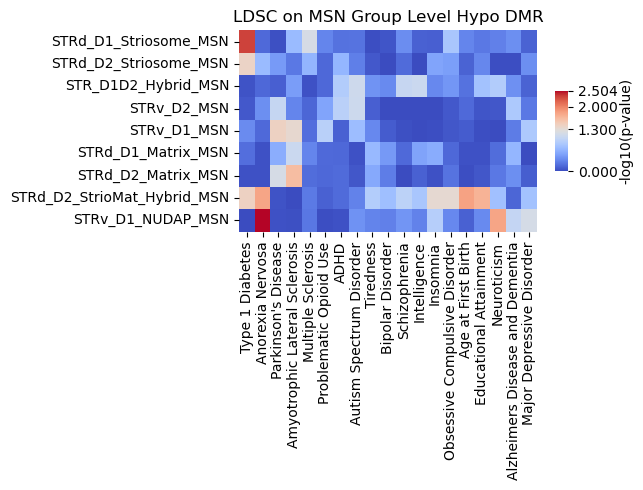

In [ ]:
if len(cols_to_keep) > 0:
    stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

    # Plot heatmap with annotations
    plt.figure(figsize=(25, 15))
    sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with FDR corrected p value stars")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
    plt.show()
else:
    # Plot heatmap with annotations
    vmax = modified_df.max().max()
    fig, ax = plt.subplots(figsize=(6.5, 5))
    sns.heatmap(modified_df, fmt='', cmap='coolwarm', 
                cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6}, 
                annot_kws=dict(ha='center',va='center'), 
                ax = ax)
    plt.title("LDSC on MSN Group Level Hypo DMR")
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    cbar = ax.collections[0].colorbar
    cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
    cbar.set_ticks([0,1.3,2,vmax])

    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf') # you can change the directory 
    plt.show()

2.5040313882585825


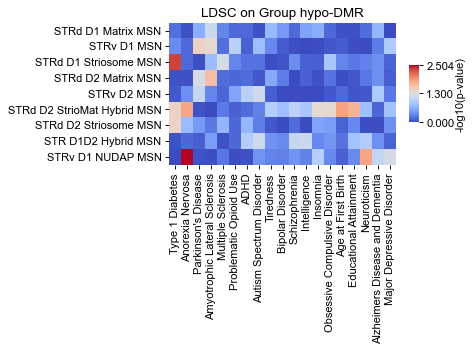

In [79]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
vmax=modified_df.loc[row_order,:].max().max()
print(vmax)
fig, ax = plt.subplots(figsize=(6, 4.5))
ax=sns.heatmap(modified_df.loc[row_order,:], 
               fmt='', cmap='coolwarm',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),#vmin=0,vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title("LDSC on Group hypo-DMR")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([0,1.3,vmax])
plt.tight_layout()
# plt.savefig(f'{run_id}_filtered_FDR.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/Group.hypo-DMR.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()